# Preliminary

In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from dataclasses import dataclass
from types import SimpleNamespace
from dateutil.relativedelta import relativedelta
from typing import NamedTuple

plt.rcParams["figure.figsize"] = (8,5)

BOND_CSV = Path(".") / "bond.csv"
DB_MODEL_CSV = Path(".") / "db_model.csv"
SETTLEMENT_DATE = pd.Timestamp("2025-10-31")
DAY_COUNT = "ACT/ACT"
COMPOUNDING = "cont"  # "cont", "annual", or "semi"

np.random.seed(42)

bonds = pd.read_csv(
    BOND_CSV,
    sep=";",
    decimal=",",
    encoding="utf-8-sig",
    dayfirst=True,
    parse_dates=["maturity_date"]
)

db_model = pd.read_csv(
    DB_MODEL_CSV,
    sep=";",
    decimal=",",
    encoding="utf-8-sig",
    dayfirst=True,
)
db_model["y_model"] = db_model["y_model"].str.rstrip("%").astype(float) / 100

print(bonds)
print(db_model)


   maturity_date  coupon_rate  current_price
0     2004-02-15        3.000       101.0544
1     2004-08-15        2.125       100.9254
2     2005-02-15        1.500        99.8942
3     2005-08-15        6.500       109.0934
4     2006-02-15        5.625       108.4380
5     2006-08-15        2.375        99.7848
6     2007-02-15        6.250       111.7184
7     2007-08-15        3.250       101.0841
8     2008-02-15        3.000        99.1692
9     2008-08-15        3.250        99.2710
10    2009-02-15        5.500       109.7707
11    2009-08-15        6.000       112.1450
12    2010-02-15        6.500       114.9084
13    2010-08-15        5.750       110.3894
14    2011-02-15        5.000       105.2934
15    2011-08-15        5.000       104.7607
16    2012-02-15        4.875       103.4391
17    2012-08-15        4.375        99.2806
18    2013-02-15        3.875        95.0288
19    2013-08-15        4.250        97.7693
20    2014-02-15       13.250       174.3251
21    2014

C:\Users\mc160\AppData\Local\Temp\ipykernel_12024\2826652741.py:20: UserWarning: Parsing dates in MM/DD/YYYY format when dayfirst=True was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  bonds = pd.read_csv(


In [ ]:

# ------------------------
# Day-count & small utils
# ------------------------


def yearfrac(start, end, day_count="ACT/ACT"):
    a = _to_ts(start); b = _to_ts(end)
    days = (b - a).days
    if str(day_count).upper() in ("ACT/365", "ACT/365F"):
        return days / 365.0
    return days / 365.0  # simple ACT/ACT



def _face_from_row(r, default=100.0):
    return float(r.get("face", default))





# ------------------------
# DF <-> ZC yield
# ------------------------




# ------------------------
# Relative value vs model ZC
# ------------------------



# Q1 Boostrapping


# Q1.1

Solve  for  the  prices  of  discount  bonds  given  the  market  prices  of  coupon  bonds  and identify the zero-coupon yields from the prices of zero-coupon bonds.


In [27]:
## Helper functions

# Helper function: get frequence from bonds DataFrame
def get_freq(bonds, default=2):
    return int(bonds["frequency"].mode().iloc[0]) if "frequency" in bonds.columns else default

# Helper function: convert coupon rate from provided data to decimal
def _clean_coupon_rate(x):
    x = float(x)
    return x/100.0 if x > 1.0 else x

# Helper function: get price from bonds DataFrame
def get_price(r):
    for c in ("clean_price","current_price","Price","price"):
        if c in r and pd.notna(r[c]):
            return float(r[c])
    return float(r.get("P", np.nan))

# Helper function: compute accrued interest
def compute_accrued(coupon_rate, face, freq, settlement, maturity):
    if settlement >= maturity:
        return 0.0
    period = relativedelta(months=int(12/freq))
    d = maturity
    while d - period > settlement:
        d -= period
    last_coupon = d - period
    next_coupon = d
    days = (next_coupon - last_coupon).days
    elapsed = (settlement - last_coupon).days
    frac = max(0.0, min(1.0, elapsed / days if days>0 else 0.0))
    cpn = coupon_rate/freq * face
    return cpn * frac

# Helper function: ZC yield from DF
def zc_yield_from_df(df, T, comp="cont"):
    df = np.asarray(df, float); T = np.asarray(T, float)
    T = np.maximum(T, 1e-8)
    if comp == "cont":
        return -np.log(df)/T
    if comp in ("annual","ann"):
        return df**(-1.0/T) - 1.0
    if comp in ("semi","semiannual"):
        return 2.0*(df**(-1.0/(2.0*T)) - 1.0)
    raise ValueError("Unknown compounding")

       T        DF      y_zc
0    0.5  0.995610  0.008800
1    1.0  0.988176  0.011894
2    1.5  0.976738  0.015691
3    2.0  0.963406  0.018640
4    2.5  0.947375  0.021624
5    3.0  0.928970  0.024560
6    3.5  0.907564  0.027712
7    4.0  0.887418  0.029860
8    4.5  0.864791  0.032282
9    5.0  0.841559  0.034500
10   5.5  0.819380  0.036220
11   6.0  0.794000  0.038445
12   6.5  0.769343  0.040341
13   7.0  0.746507  0.041764
14   7.5  0.724062  0.043051
15   8.0  0.701204  0.044369
16   8.5  0.680072  0.045360
17   9.0  0.660381  0.046104
18   9.5  0.643389  0.046422
19  10.0  0.627754  0.046561
20  10.5  0.611738  0.046805
21  11.0  0.585340  0.048687
22  11.5  0.546185  0.052591
23  12.0  0.528678  0.053115
24  12.5  0.509846  0.053892
25  13.0  0.492711  0.054449
26  13.5  0.476050  0.054980
27  14.0  0.457551  0.055848
28  14.5  0.444315  0.055946
29  15.0  0.429353  0.056365
30  15.5  0.412853  0.057075
31  16.0  0.398744  0.057465
32  16.5  0.386180  0.057664
33  17.0  0.37

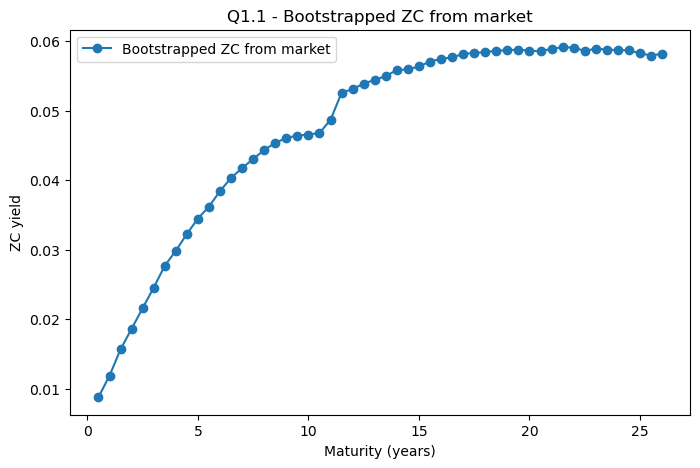

In [28]:
## Boostrapping function

def bootstrap(bonds: pd.DataFrame, settlement=None, compounding="cont", day_count="ACT/ACT", enforce_monotonic=True, clip_eps=1e-10):
    df = bonds.copy().sort_values("maturity_date").reset_index(drop=True)
    n = len(df)
    if n == 0:
        raise ValueError("bonds is empty")

    freq = get_freq(df, 2) # default is set as semi-annual (it as in our assumptions)

    # Settlement par défaut: une période avant la 1ère maturité
    if settlement is None:
        first = pd.Timestamp(df.loc[0, "maturity_date"])
        settlement = first - relativedelta(months=int(12/freq))
    settlement = pd.Timestamp(settlement)

    period_years = 1.0 / freq

    # Standardisation
    df["coupon_rate"] = df["coupon_rate"].apply(_clean_coupon_rate).astype(float)
    faces = df.get("face", pd.Series([100.0]*n)).astype(float).values
    maturities = [pd.Timestamp(x) for x in df["maturity_date"]]
    prices_clean = np.array([get_price(r) for _, r in df.iterrows()], float)

    # Dirty = clean + accrued (si clean seulement)
    if "clean_price" in df.columns and "price" not in df.columns:
        prices_dirty = prices_clean.copy()
        for i in range(n):
            ai = compute_accrued(df.loc[i,"coupon_rate"], faces[i], freq, settlement, maturities[i])
            prices_dirty[i] = prices_clean[i] + ai
    else:
        prices_dirty = prices_clean

    # Grille régulière
    T = np.arange(1, n+1, dtype=float) * period_years

    # Matrice des cashflows
    cpn_per_period = (df["coupon_rate"].values / freq) * faces
    A = np.zeros((n, n), float)
    for i in range(n):
        A[i, :i+1] = cpn_per_period[i]
        A[i, i] += faces[i]

    # Substitution avant (système triangulaire inférieure)
    DF = np.zeros(n, float)
    for i in range(n):
        rhs = prices_dirty[i] - float(np.dot(A[i, :i], DF[:i]))
        DF[i] = rhs / A[i, i]

    # Contraintes pédagogiques
    if enforce_monotonic:
        DF = np.maximum(DF, clip_eps)
        for i in range(1, n):
            if DF[i] > DF[i-1]:
                DF[i] = DF[i-1]

    y = zc_yield_from_df(DF, T, compounding)
    try:
        return BootstrapResult(maturities=T, dfs=DF, zc_yields=y)
    except NameError:
        # Fallback minimal si BootstrapResult absent
        class _BootstrapResult(NamedTuple):
            maturities: np.ndarray
            dfs: np.ndarray
            zc_yields: np.ndarray
        return _BootstrapResult(maturities=T, dfs=DF, zc_yields=y)
    

## Results
bootstrap = bootstrap(bonds, settlement=SETTLEMENT_DATE, compounding=COMPOUNDING, day_count=DAY_COUNT)
mkt_zc = pd.DataFrame({"T": bootstrap.maturities, "DF": bootstrap.dfs, "y_zc": bootstrap.zc_yields})
print(mkt_zc)
mkt_zc.to_csv("q11_bootstrapped_zc_yields.csv", index=False)

# Plot zero-coupon yields
plt.figure()
plt.plot(mkt_zc["T"], mkt_zc["y_zc"], marker="o", linestyle="-", label="Bootstrapped ZC from market")
plt.xlabel("Maturity (years)")
plt.ylabel("ZC yield")
plt.legend()
plt.title("Q1.1 - Bootstrapped ZC from market")
plt.savefig("q11_bootstrapped_zc_yields.png")
plt.show()


# Q1.2
Compare the zero-coupon yields from Deutsche Bank's model (in Exhibit 4 of the case) to 
the  market  zero-coupon  yields,  and  identify  which  zero-coupon  bonds  Deutsche  Bank should buy, and which ones they should sell. Load the model zero-coupon yields and generate buy/sell signals based on relative value.


In [29]:
# Helper function: DF from ZC yield
def df_from_zc_yield(y, T, comp="cont"):
    y = np.asarray(y, float); T = np.asarray(T, float)
    T = np.maximum(T, 1e-8)
    if comp == "cont":
        return np.exp(-y*T)
    if comp in ("annual","ann"):
        return (1.0 + y)**(-T)
    if comp in ("semi","semiannual"):
        return (1.0 + y/2.0)**(-2.0*T)
    raise ValueError("Unknown compounding")

       T  y_market   y_model  DF_market  DF_model   signal
0    0.5  0.008800  0.012443   0.995610  0.993798  Sell ZC
1    1.0  0.011894  0.012443   0.988176  0.987634  Sell ZC
2    1.5  0.015691  0.015585   0.976738  0.976894   Buy ZC
3    2.0  0.018640  0.018727   0.963406  0.963239  Sell ZC
4    2.5  0.021624  0.021419   0.947375  0.947862   Buy ZC
5    3.0  0.024560  0.024110   0.928970  0.930224   Buy ZC
6    3.5  0.027712  0.026888   0.907564  0.910186   Buy ZC
7    4.0  0.029860  0.029665   0.887418  0.888110   Buy ZC
8    4.5  0.032282  0.032059   0.864791  0.865656   Buy ZC
9    5.0  0.034500  0.034454   0.841559  0.841752   Buy ZC
10   5.5  0.036220  0.036505   0.819380  0.818092  Sell ZC
11   6.0  0.038445  0.038557   0.794000  0.793468  Sell ZC
12   6.5  0.040341  0.040277   0.769343  0.769667   Buy ZC
13   7.0  0.041764  0.041996   0.746507  0.745297  Sell ZC
14   7.5  0.043051  0.043337   0.724062  0.722510  Sell ZC
15   8.0  0.044369  0.044677   0.701204  0.699481  Sell 

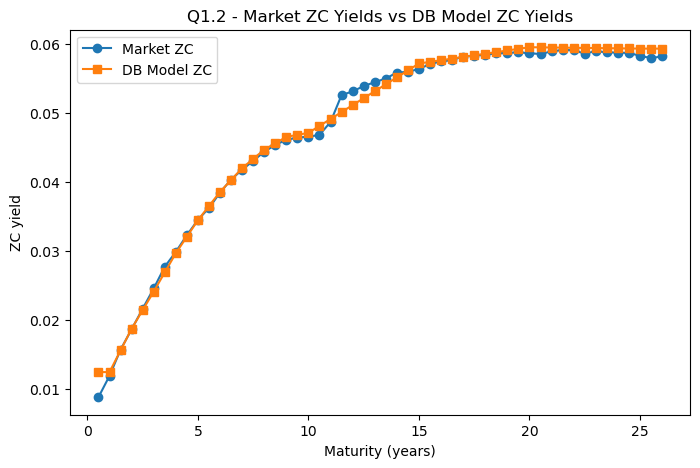

In [30]:
# Comparison market vs DB model

db_sortedT = db_model.sort_values("T")
interpolation = np.interp(mkt_zc["T"].values, db_sortedT["T"].values, db_sortedT["y_model"].values)

# Buy or Sell decision:
# ym>yb => "Buy ZC" 
# versus 
# ym<yb => "Sell ZC"
T = np.asarray(mkt_zc["T"].values, float)
ym = np.asarray(mkt_zc["y_zc"].values, float)
yb = np.asarray(interpolation, float)
df_mkt = df_from_zc_yield(ym, T, COMPOUNDING) # just to check if the prices are consistent with yields decision when buying/selling
df_mod = df_from_zc_yield(yb, T, COMPOUNDING) # just to check if the prices are consistent with yields decision when buying/selling
signal = np.where(ym > yb, "Buy ZC", "Sell ZC")  # marché > modèle => ZC bon marché
Comparison = pd.DataFrame({
    "T": T, "y_market": ym, "y_model": yb,
    "DF_market": df_mkt, "DF_model": df_mod,
    "signal": signal
    })
print(Comparison)
Comparison.to_csv("q12_market_vs_db_model_comparison.csv", index=False)

# Plot comparison
plt.figure()
plt.plot(mkt_zc["T"], mkt_zc["y_zc"], marker="o", label="Market ZC")
plt.plot(mkt_zc["T"], interpolation, marker="s", label="DB Model ZC")
plt.xlabel("Maturity (years)")
plt.ylabel("ZC yield")
plt.legend()
plt.title("Q1.2 - Market ZC Yields vs DB Model ZC Yields")
plt.savefig("q12_market_vs_db_model_zc_yields.png")
plt.show()



# Q1.3

Is this strategy (of buying some bonds and selling others) a risk-free arbitrage strategy?


In [31]:

q13 = """
The proposed strategy cannot be considered risk-free. The differences observed 
between the Deutsche Bank model yields and the market zero-coupon yields do not 
necessarily reflect arbitrage opportunities but rather small inconsistencies due 
to modeling assumptions, data limitations, or market frictions. Entering long positions
on some maturities and short positions on others exposes the trader to changes in 
the overall level and shape of the yield curve, as well as to funding and roll risks. 
In addition, practical elements such as liquidity constraints, transaction costs, and 
differences in compounding or day-count conventions can significantly affect the outcome.
Even though these exposures can be partially hedged, they can never be fully neutralized. 
The strategy therefore represents a relative-value position that seeks to exploit pricing
differences, but it is not a true risk-free arbitrage.

"""
print(q13)



The proposed strategy cannot be considered risk-free. The differences observed 
between the Deutsche Bank model yields and the market zero-coupon yields do not 
necessarily reflect arbitrage opportunities but rather small inconsistencies due 
to modeling assumptions, data limitations, or market frictions. Entering long positions
on some maturities and short positions on others exposes the trader to changes in 
the overall level and shape of the yield curve, as well as to funding and roll risks. 
In addition, practical elements such as liquidity constraints, transaction costs, and 
differences in compounding or day-count conventions can significantly affect the outcome.
Even though these exposures can be partially hedged, they can never be fully neutralized. 
The strategy therefore represents a relative-value position that seeks to exploit pricing
differences, but it is not a true risk-free arbitrage.




# Q2 Cubic splines


# Q2.1

Estimate the cubic splines’ function that uses as knots 2-, 5-,10-, 15- and 20-year zero-coupon  yields. Describe  succinctly  the  methodology  and document any  choice made in the estimation. 

Plot the discount function (i.e., the cubic splines based ZC yields) against the zero-coupon yields obtained in Q1.1.


In [51]:
## Helper functions for spline evaluation

# Helper function: compute natural cubic spline coefficients
def _natural_cubic_coeffs(x, y):

    x = np.asarray(x, float); y = np.asarray(y, float)
    n = x.size
    if n < 2:
        a = y[:-1] if n>1 else np.array([float(y[0])])
        return {"x": x, "a": a, "b": np.zeros(max(n-1,1)),
                "c": np.zeros(max(n,1)), "d": np.zeros(max(n-1,1))}

    h = np.diff(x)
    if np.any(h <= 0):
        raise ValueError("x doit être strictement croissant (sans doublons).")

    alpha = np.zeros(n)
    for i in range(1, n-1):
        alpha[i] = (3/h[i])*(y[i+1]-y[i]) - (3/h[i-1])*(y[i]-y[i-1])

    l  = np.ones(n)
    mu = np.zeros(n)
    z  = np.zeros(n)
    for i in range(1, n-1):
        l[i]  = 2*(x[i+1]-x[i-1]) - h[i-1]*mu[i-1]
        mu[i] = h[i] / l[i]
        z[i]  = (alpha[i] - h[i-1]*z[i-1]) / l[i]

    c = np.zeros(n)
    b = np.zeros(n-1)
    d = np.zeros(n-1)
    for j in range(n-2, -1, -1):
        c[j] = z[j] - mu[j]*c[j+1]
        b[j] = (y[j+1]-y[j]) / h[j] - h[j]*(c[j+1] + 2*c[j]) / 3.0
        d[j] = (c[j+1]-c[j]) / (3.0*h[j])

    a = y[:-1]
    return {"x": x, "a": a, "b": b, "c": c[:-1], "d": d}

# Helper function: fit cubic spline to data
def cubic_spline(T, y, knots):
    
    T = np.asarray(T, float); y = np.asarray(y, float)
    m = np.isfinite(T) & np.isfinite(y)
    T, y = T[m], y[m]
    if T.size == 0:
        raise ValueError("fit_cubic_spline: données vides")

    idx = np.argsort(T); T, y = T[idx], y[idx]
    uniq_T, inv = np.unique(T, return_inverse=True)
    if uniq_T.size != T.size:
        y_sum = np.zeros_like(uniq_T, float)
        cnt   = np.zeros_like(uniq_T, float)
        for k, yi in zip(inv, y):
            y_sum[k] += yi; cnt[k] += 1.0
        T, y = uniq_T, y_sum / np.where(cnt==0, 1.0, cnt)

    k = np.asarray(knots, float) if knots is not None else np.array([])
    interior = k[(k > T.min()) & (k < T.max())]
    xk = np.unique(np.concatenate(([T.min()], interior, [T.max()])))

    yk = np.interp(xk, T, y) # interpolation linéaire des y aux noeuds xk
    coeffs = _natural_cubic_coeffs(xk, yk)
    return coeffs  # dict(x,a,b,c,d)

# Helper function: evaluate natural cubic spline at query points
def _eval_natural_cubic(xq, coeffs):

    x = coeffs["x"]; a = coeffs["a"]; b = coeffs["b"]; c = coeffs["c"]; d = coeffs["d"]
    xq = np.asarray(xq, float)
    n = x.size
    i = np.searchsorted(x, xq, side="right") - 1
    i = np.clip(i, 0, n-2)
    dx = xq - x[i]
    return a[i] + b[i]*dx + c[i]*dx*dx + d[i]*dx*dx*dx

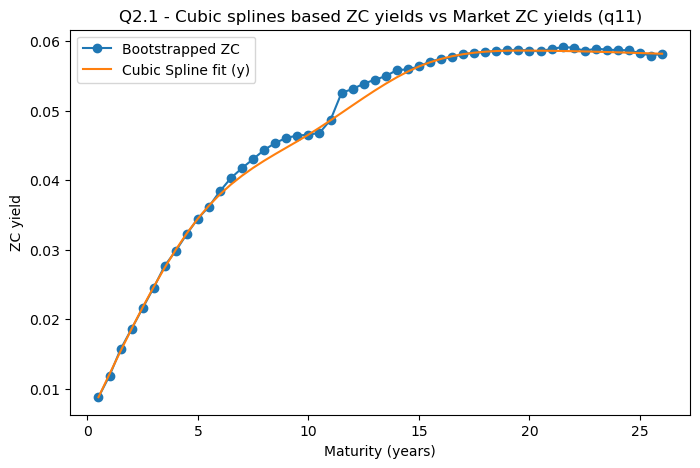

In [55]:
knots = [2.0, 5.0, 10.0, 15.0, 20.0]
spl = cubic_spline(mkt_zc["T"].values, mkt_zc["y_zc"].values, knots)

plt.figure()
plt.plot(mkt_zc["T"], mkt_zc["y_zc"], marker="o", linestyle="-", label="Bootstrapped ZC")
plt.plot(mkt_zc["T"], _eval_natural_cubic(mkt_zc["T"], spl), linestyle="-", label="Cubic Spline fit (y)")
plt.xlabel("Maturity (years)")
plt.ylabel("ZC yield")
plt.legend()
plt.savefig("q21_spline_vs_bootstrapped_zc.png")
plt.title("Q2.1 - Cubic splines based ZC yields vs Market ZC yields (q11)")
plt.show()


# Q2.2

Discuss when using those new ‘spline-based’ zero-coupon yields estimates instead of the 
one implied by the bootstrapped zero-coupon bonds in Q1.1 is appropriate. 

Please justify and discuss whether this affects the conclusions reached in Q1.2?


In [49]:
q22 = """
Using spline-based zero-coupon yields instead of the bootstrapped ones is appropriate 
when a smooth and continuous yield curve is required for applications such as bond 
pricing, risk management, or sensitivity analysis. The bootstrapped curve, while fully 
consistent with market bond prices, can sometimes display small irregularities caused by 
discrete maturities, data noise, or rounding in quoted prices. The spline interpolation 
removes these local inconsistencies and produces a term structure that behaves more 
realistically between observed maturities. This makes the spline approach particularly 
suitable for valuing instruments with cash flows that do not match the maturities of the 
underlying bonds, or for calculating key rate durations and forward rates.

However, using spline-based yields means slightly moving away from the exact market 
consistency of the bootstrapped curve. The spline curve smooths out minor differences 
that might represent actual pricing information, so it should be viewed as a convenient 
analytical approximation rather than a perfect market replica.

Regarding the conclusions from Q1.2, the comparison between the market and Deutsche 
Bank’s model zero-coupon yields would not fundamentally change. The spline-based curve 
follows the same general shape as the bootstrapped curve, and the relative differences 
between market and model yields remain essentially the same. At most, the smoothing 
might reduce very small discrepancies at certain maturities, but it would not alter the 
overall buy and sell recommendations. Therefore, while the spline improves the curve’s 
smoothness and usability, it does not materially affect the economic interpretation 
of Q1.2.
"""
print(q22)


Using spline-based zero-coupon yields instead of the bootstrapped ones is appropriate 
when a smooth and continuous yield curve is required for applications such as bond 
pricing, risk management, or sensitivity analysis. The bootstrapped curve, while fully 
consistent with market bond prices, can sometimes display small irregularities caused by 
discrete maturities, data noise, or rounding in quoted prices. The spline interpolation 
removes these local inconsistencies and produces a term structure that behaves more 
realistically between observed maturities. This makes the spline approach particularly 
suitable for valuing instruments with cash flows that do not match the maturities of the 
underlying bonds, or for calculating key rate durations and forward rates.

However, using spline-based yields means slightly moving away from the exact market 
consistency of the bootstrapped curve. The spline curve smooths out minor differences 
that might represent actual pricing information, s


# Q2.3

Re-estimate the cubic splines’ function only using as knots 5- and 20-year zero-coupon 
yields. Plot the discount function against the one obtained in Q2.1. 

Discuss how changing the knots affects the estimated discount function.


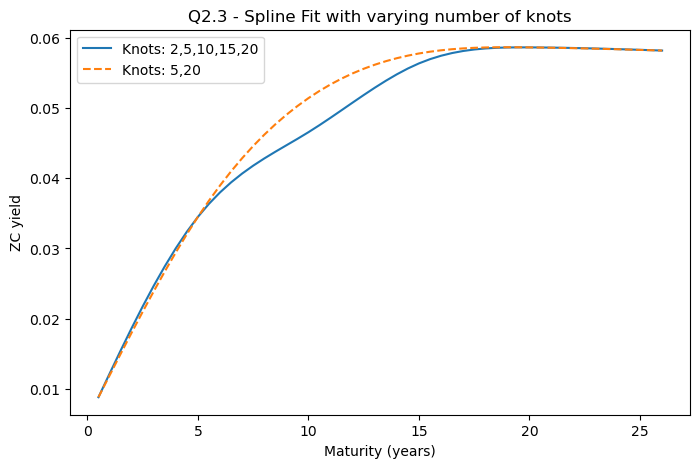

In [ ]:
# -- spline 1 : nœuds 2,5,10,15,20 => see Q2.1 above

# -- spline 2 : nœuds 5,20
spl_2_knots_only = cubic_spline(mkt_zc["T"].values, mkt_zc["y_zc"].values, [5.0, 20.0])
_eval_natural_cubic(mkt_zc["T"], spl_2_knots_only)

plt.figure()
plt.plot(mkt_zc["T"], _eval_natural_cubic(mkt_zc["T"], spl), label="Knots: 2,5,10,15,20") # from Q2.1
plt.plot(mkt_zc["T"], _eval_natural_cubic(mkt_zc["T"], spl_2_knots_only), label="Knots: 5,20", linestyle="--")
plt.xlabel("Maturity (years)")
plt.ylabel("ZC yield")
plt.legend()
plt.title("Q2.3 - Spline Fit with varying number of knots")
plt.savefig("q23_spline_knots_number.png")
plt.show()

In [324]:
# ------------------------
# Nelson–Siegel–Svensson 
# ------------------------

def _nss_loadings(T, tau1, tau2):
    T = np.asarray(T, float)
    t1 = T / max(tau1, 1e-6)
    t2 = T / max(tau2, 1e-6)
    # Éviter la division par zéro : pour T=0, on prend la limite (1 - e^{-x})/x -> 1
    S  = (1 - np.exp(-t1)) / np.where(T == 0.0, 1.0, t1)
    C1 = S - np.exp(-t1)
    S2 = (1 - np.exp(-t2)) / np.where(T == 0.0, 1.0, t2)
    C2 = S2 - np.exp(-t2)
    L  = np.ones_like(T)
    return np.column_stack([L, S, C1, C2])  # colonnes: Level, Slope, Curv1, Curv2

def nss_factor_loadings(T, params):
    X = _nss_loadings(T, params["tau1"], params["tau2"])
    return pd.DataFrame({
        "T": np.asarray(T, float),
        "Level":      X[:, 0],
        "Slope":      X[:, 1],
        "Curvature1": X[:, 2],
        "Curvature2": X[:, 3],
    })

def fit_nss(T, y, init=None):
    """
    Grid-search sur (tau1, tau2), OLS fermée pour (beta0..beta3) via lstsq.
    Retourne:
      params: dict {beta0..beta3, tau1, tau2}
      yhat:   np.ndarray prédictions aux T donnés
    """
    T = np.asarray(T, float)
    y = np.asarray(y, float)

    # grille simple (cours) — ajuste si besoin
    tau1_grid = np.linspace(0.5, 5.0, 20)
    tau2_grid = np.linspace(5.0, 15.0, 20)

    best_sse = np.inf
    best = None

    for tau1 in tau1_grid:
        for tau2 in tau2_grid:
            X = _nss_loadings(T, tau1, tau2)
            beta, *_ = np.linalg.lstsq(X, y, rcond=None)
            yhat = X @ beta
            sse = float(np.sum((y - yhat) ** 2))
            if sse < best_sse:
                best_sse = sse
                best = (beta, tau1, tau2, yhat)

    b0, b1, b2, b3 = best[0]
    params = {
        "beta0": b0, "beta1": b1, "beta2": b2, "beta3": b3,
        "tau1":  best[1], "tau2":  best[2],
    }
    yhat = best[3]
    return params, yhat

def nss_yield_function(params):
    """Renvoie une fonction y(T) = X(T)*beta (utile pour tracer/évaluer)."""
    beta = np.array([params["beta0"], params["beta1"], params["beta2"], params["beta3"]], float)
    tau1 = float(params["tau1"]); tau2 = float(params["tau2"])
    return lambda t: _nss_loadings(np.asarray(t, float), tau1, tau2) @ beta

def nss_discount_function(params, comp="cont"):
    """
    Transforme le NSS (sur taux zéro) en DF(t).
    Requiert df_from_zc_yield(y, t, comp) existant dans ton code.
    """
    y_func = nss_yield_function(params)
    def df_func(t):
        t = np.asarray(t, float)
        return df_from_zc_yield(y_func(t), t, comp)
    return df_func


# Q3.1

Estimate the discount function according to the Nelson-Siegel-Svensson model. 

Describe succinctly  the  methodology  and  document  any  choice  made  in  the  estimation. 

Plot  it against the zero-coupon yields obtained in Q1.1.


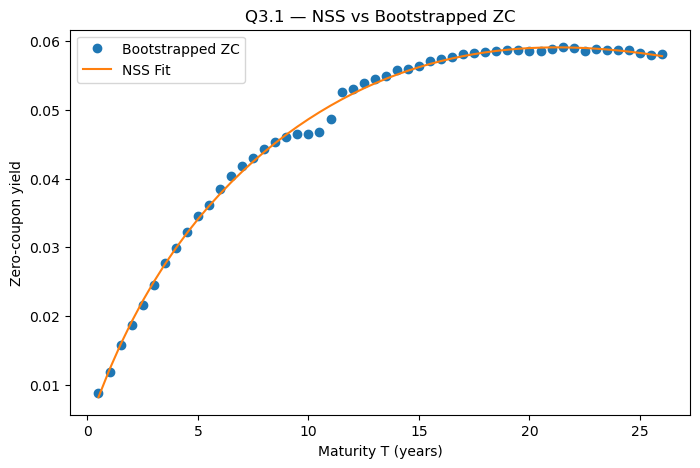

NSS parameters: {'beta0': np.float64(-0.07002221109457318), 'beta1': np.float64(0.07369065209867698), 'beta2': np.float64(0.05376197292687899), 'beta3': np.float64(0.37380969341552295), 'tau1': np.float64(3.3421052631578947), 'tau2': np.float64(15.0)}


In [325]:

params, y_nss = fit_nss(df_q11["T"].values, df_q11["y_zc"].values, init=None)
df_func_nss = nss_discount_function(params, comp=COMPOUNDING)

plt.figure()
plt.plot(df_q11["T"], df_q11["y_zc"], marker="o", linestyle="", label="Bootstrapped ZC")
plt.plot(df_q11["T"], y_nss, linestyle="-", label="NSS Fit")
plt.xlabel("Maturity T (years)")
plt.ylabel("Zero-coupon yield")
plt.legend()
plt.title("Q3.1 — NSS vs Bootstrapped ZC")
plt.show()

print("NSS parameters:", params)


## Q3.2 — Compare spline vs NSS fit


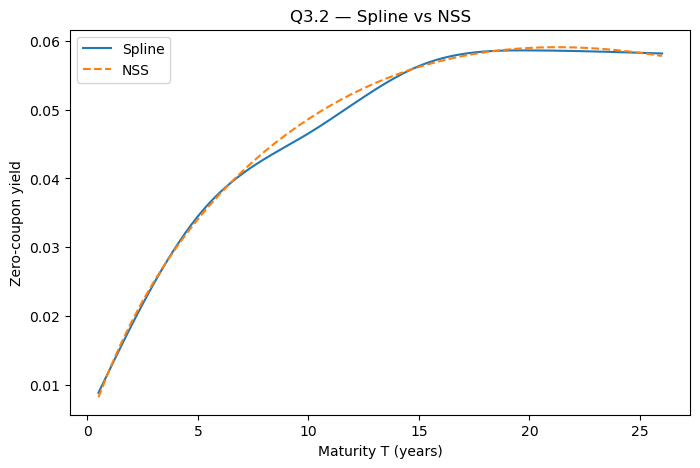

In [326]:

plt.figure()
plt.plot(T_grid, y_spline, label="Spline")
plt.plot(df_q11["T"], y_nss, label="NSS", linestyle="--")
plt.xlabel("Maturity T (years)")
plt.ylabel("Zero-coupon yield")
plt.legend()
plt.title("Q3.2 — Spline vs NSS")
plt.show()



## Q3.3 — Factor loadings and contributions


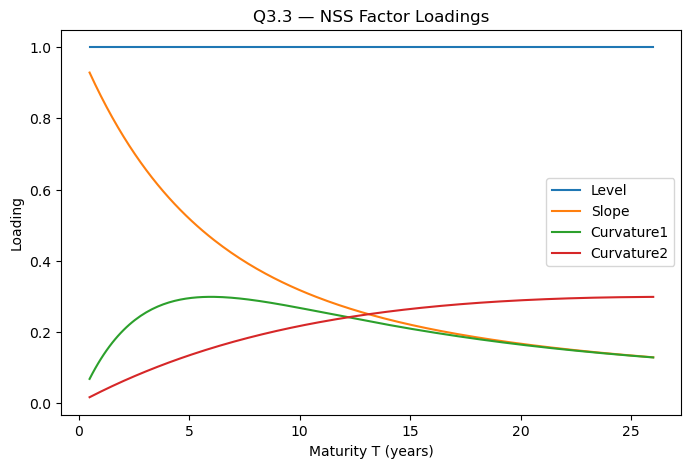

In [327]:
params, y_nss = fit_nss(df_q11["T"].values, df_q11["y_zc"].values)
fl = nss_factor_loadings(T_grid, params)

plt.figure()
plt.plot(fl["T"], fl["Level"], label="Level")
plt.plot(fl["T"], fl["Slope"], label="Slope")
plt.plot(fl["T"], fl["Curvature1"], label="Curvature1")
plt.plot(fl["T"], fl["Curvature2"], label="Curvature2")
plt.xlabel("Maturity T (years)")
plt.ylabel("Loading")
plt.legend()
plt.title("Q3.3 — NSS Factor Loadings")
plt.show()

In [328]:

# ------------------------
# Pricing & KRD
# ------------------------
def _regular_schedule(settlement, maturity, freq):
    # grille régulière depuis settlement (approx) jusqu’à maturity
    T = yearfrac(settlement, maturity)
    n = max(1, int(round(T * freq)))
    return np.arange(1, n+1, dtype=float) / float(freq)

def price_bond_from_curve(settlement, maturity_date, coupon_rate, frequency, face, day_count, df_func):
    settlement = _to_ts(settlement); maturity_date = _to_ts(maturity_date)
    freq = int(frequency)
    cpn = _clean_coupon_rate(coupon_rate) * face / freq
    T = _regular_schedule(settlement, maturity_date, freq)
    D = df_func(T)
    return float(np.dot(np.full_like(T, cpn, dtype=float), D) + face * D[-1])

def portfolio_krd(bonds_df, settlement, key_maturities, shock_bps=50,
                  base_df_func=None, comp="cont", day_count="ACT/ACT"):
    keys = np.asarray(key_maturities, float)
    shock = float(shock_bps) / 1e4  # 50 bps -> 0.005

    def _y_base(t):
        t = np.asarray(t, float)
        return zc_yield_from_df(base_df_func(t), t, comp)

    rows = []
    width = 0.50  # largeur locale (années) du bump clé
    for k in keys:
        def bumped_df_func(t):
            t = np.asarray(t, float)
            yb = _y_base(t) + shock * np.exp(-0.5*((t - k)/width)**2)
            return df_from_zc_yield(yb, t, comp)

        # ΔP/P pondéré par 'weight' si présent, sinon égal-pondéré
        rel_changes, weights = [], []
        for _, r in bonds_df.iterrows():
            face = _face_from_row(r)
            P0 = price_bond_from_curve(settlement, r["maturity_date"], r["coupon_rate"],
                                       int(r.get("frequency", 2)), face, day_count, base_df_func)
            P1 = price_bond_from_curve(settlement, r["maturity_date"], r["coupon_rate"],
                                       int(r.get("frequency", 2)), face, day_count, bumped_df_func)
            w = float(r.get("weight", 1.0))
            rel_changes.append((P1 - P0) / P0)
            weights.append(w)
        weights = np.asarray(weights, float)
        rel_changes = np.asarray(rel_changes, float)
        wsum = weights.sum() if weights.sum()!=0 else len(weights)
        rel_port = float((weights * rel_changes).sum() / wsum)
        krd = - rel_port / shock
        rows.append({"key_maturity": k, "KRD": krd})
    return pd.DataFrame(rows)



## Q4.1 — 10-year key-rate +50 bps shock — impact on the curve


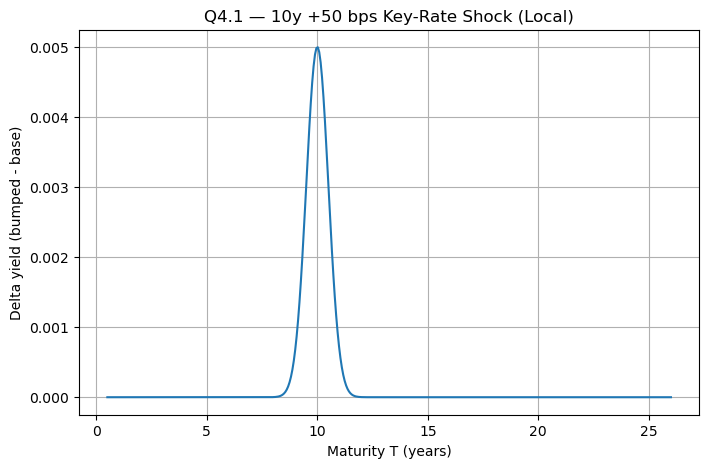

In [329]:
# Build base DF function from the spline fit (smooth base for risk work)
base_df_func = spline_discount_function(spl, comp=COMPOUNDING)

T_min = float(pd.to_numeric(df_q11["T"], errors="coerce").min())
T_max = float(pd.to_numeric(df_q11["T"], errors="coerce").max())
T_grid_dense = np.linspace(T_min, T_max, 400)

width = 0.50
bump = 0.0050  # 50 bps

#  utiliser l’évaluateur sur les coeffs
y_base = _eval_natural_cubic(T_grid_dense, spl)

weights = np.exp(-0.5 * ((T_grid_dense - 10.0) / width)**2)
y_bumped = y_base + bump * weights

plt.figure()
plt.plot(T_grid_dense, y_bumped - y_base)
plt.xlabel("Maturity T (years)")
plt.ylabel("Delta yield (bumped - base)")
plt.title("Q4.1 — 10y +50 bps Key-Rate Shock (Local)")
plt.grid(True)
plt.show()



## Q4.2 — Portfolio KRD to 10y shock

Assume $1,000,000 notional, equally invested across bonds.


In [330]:

bonds_w = bonds.copy()
n = len(bonds_w)
bonds_w["weight"] = 1_000_000.0 / n  # equal capital-weight

krd_10 = portfolio_krd(bonds_w, SETTLEMENT_DATE, key_maturities=np.array([10.0]), shock_bps=50,
                       base_df_func=base_df_func, comp=COMPOUNDING, day_count=DAY_COUNT)
display(krd_10)


,key_maturity,KRD
0,10.0,-0.0



## Q4.3 — Portfolio KRDs across all maturities (apply same shock individually)


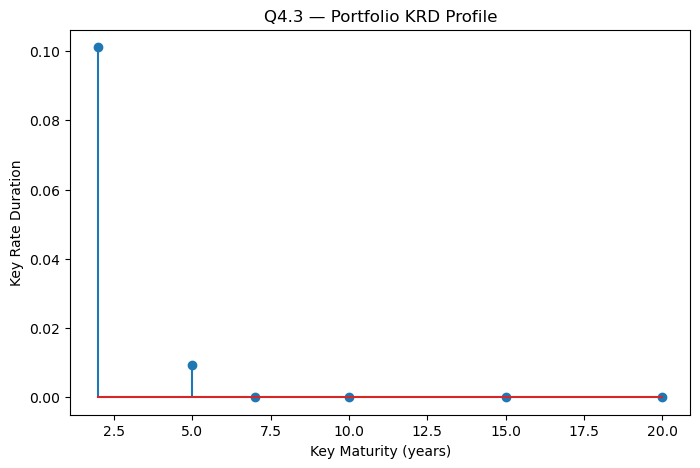

In [331]:
# === Normalisation du DataFrame obligataire ===
bonds_w = bonds.copy()

# Frequency par défaut = mode si dispo sinon 2
if "frequency" in bonds_w.columns and bonds_w["frequency"].notna().any():
    FREQ_DEFAULT = int(bonds_w["frequency"].dropna().astype(int).mode().iloc[0])
else:
    FREQ_DEFAULT = 2

# Crée/Nettoie la colonne frequency
if "frequency" not in bonds_w.columns:
    bonds_w["frequency"] = FREQ_DEFAULT
else:
    bonds_w["frequency"] = bonds_w["frequency"].fillna(FREQ_DEFAULT).astype(int)

# Face & id par défaut si manquent
if "face" not in bonds_w.columns:
    bonds_w["face"] = 100.0
if "id" not in bonds_w.columns:
    bonds_w["id"] = np.arange(1, len(bonds_w) + 1)

# Pondération égale (si attendu par Q4.2/Q4.3)
n = len(bonds_w)
bonds_w["weight"] = 1_000_000.0 / n
keys = np.array([2.0, 5.0, 7.0, 10.0, 15.0, 20.0])
krd_all = portfolio_krd(bonds_w, SETTLEMENT_DATE, key_maturities=keys, shock_bps=50,
                        base_df_func=base_df_func, comp=COMPOUNDING, day_count=DAY_COUNT)


plt.figure()
plt.stem(krd_all["key_maturity"], krd_all["KRD"])
plt.xlabel("Key Maturity (years)")
plt.ylabel("Key Rate Duration")
plt.title("Q4.3 — Portfolio KRD Profile")
plt.show()



## Q5.1 — Expected steepening scenario

\( y^{Steepen}_T = y_T + \frac{T-\bar{T}}{\bar{T}} \times 0.0050 + \varepsilon \), with \(\varepsilon \sim \mathcal{N}(0, 0.0025)\).


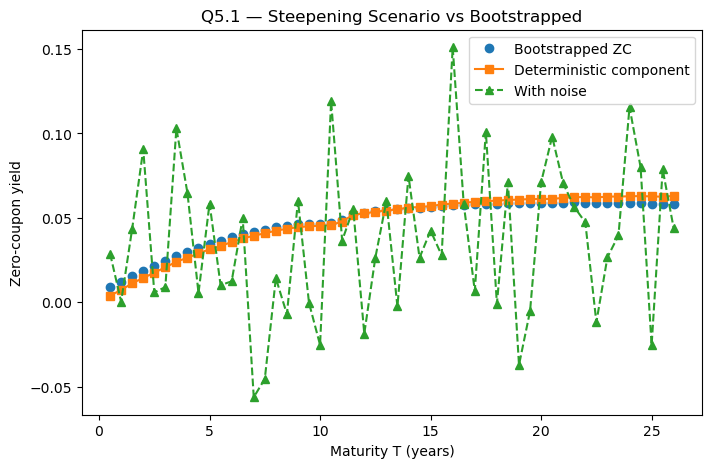

In [332]:

T = df_q11["T"].values
y0 = df_q11["y_zc"].values
Tbar = T.mean()
eps = np.random.normal(loc=0.0, scale=np.sqrt(0.0025), size=len(T))
y_det = y0 + ((T - Tbar)/Tbar)*0.0050
y_stp = y_det + eps

plt.figure()
plt.plot(T, y0, marker="o", linestyle="", label="Bootstrapped ZC")
plt.plot(T, y_det, marker="s", linestyle="-", label="Deterministic component")
plt.plot(T, y_stp, marker="^", linestyle="--", label="With noise")
plt.xlabel("Maturity T (years)")
plt.ylabel("Zero-coupon yield")
plt.legend()
plt.title("Q5.1 — Steepening Scenario vs Bootstrapped")
plt.show()



## Q5.2 — Refit NSS to expected curve and value bonds


In [333]:

nss_stp = fit_nss(T, y_stp)
params_nss_stp = nss_stp[0]  
df_func_nss_stp = nss_discount_function(params_nss_stp, comp=COMPOUNDING)

print("NSS (steepened) params:", params_nss_stp)

# Value each bond under market (spline) vs expected (NSS)
vals = []
freq = int(r.get("frequency", 2 if float(r.get("coupon_rate", 0) or 0) > 0 else 1))
for _, r in bonds.iterrows():
    P_mkt = price_bond_from_curve(SETTLEMENT_DATE, r["maturity_date"], r["coupon_rate"],
                              freq, r.get("face", 100.0), DAY_COUNT, base_df_func)
    P_exp = price_bond_from_curve(SETTLEMENT_DATE, r["maturity_date"], r["coupon_rate"],
                              freq, r.get("face", 100.0), DAY_COUNT, df_func_nss_stp)
    vals.append({
    "id": r.get("id", _),  # ← utilise l'index de la boucle si 'id' n'existe pas
    "P_market": P_mkt,
    "P_expected": P_exp,
    "cheap_vs_exp": P_exp - P_mkt
})
df_vals = pd.DataFrame(vals).sort_values("cheap_vs_exp")
display(df_vals)



NSS (steepened) params: {'beta0': np.float64(-0.7396230815936583), 'beta1': np.float64(0.703268219285158), 'beta2': np.float64(0.8385196453254096), 'beta3': np.float64(2.275409111598713), 'tau1': np.float64(1.6842105263157894), 'tau2': np.float64(14.473684210526315)}


,id,P_market,P_expected,cheap_vs_exp
48,48,109.630225,102.833787,-6.796438
47,47,108.848624,102.500982,-6.347643
49,49,108.814497,102.768568,-6.045929
46,46,107.519526,102.775620,-4.743907
50,50,108.449594,104.111556,-4.338038
45,45,105.488346,103.173945,-2.314401
51,51,111.943136,109.916141,-2.026996
20,20,106.156900,106.112227,-0.044674
21,21,105.783547,105.739030,-0.044517
22,22,105.161291,105.117036,-0.044255



## Q5.3 — Zero-cost diversified long/short portfolio

Allocate $100 of initial wealth, financing cost = 0, to harvest mispricings (expected).
Strategy: go long the 'cheap' bonds (positive `cheap_vs_exp`) and short the 'rich' ones, scaled to zero cost.


In [334]:
init_wealth = 100.0
df_pos = df_vals[df_vals["cheap_vs_exp"] > 0].copy()
df_neg = df_vals[df_vals["cheap_vs_exp"] < 0].copy()

if len(df_pos) == 0 or len(df_neg) == 0:
    print("Not enough dispersion to form a long-short. Adjust your data or scenario.")
else:
    nL = len(df_pos)
    nS = len(df_neg)
    gross = init_wealth
    long_notional = gross / 2.0
    short_notional = gross / 2.0

    df_pos["alloc_usd"] = long_notional / nL
    df_neg["alloc_usd"] = - short_notional / nS

    df_pos["exp_ret_pct"] = (df_pos["P_expected"] - df_pos["P_market"]) / df_pos["P_market"]
    df_neg["exp_ret_pct"] = (df_neg["P_expected"] - df_neg["P_market"]) / df_neg["P_market"]

    port = pd.concat([df_pos, df_neg], ignore_index=True)
    port["weight_usd"] = port["alloc_usd"]
    port["contrib_usd"] = port["weight_usd"] * port["exp_ret_pct"]

    exp_return_usd = port["contrib_usd"].sum()
    exp_return_pct = exp_return_usd / init_wealth

    display(port[["id", "P_market", "P_expected", "alloc_usd", "exp_ret_pct"]])
    print(f"Expected portfolio return ≈ {exp_return_pct:.2%}")

Not enough dispersion to form a long-short. Adjust your data or scenario.



---

# Python Labs — Trump tariffs’ threats (Event Study Skeleton)

> This section expects a local `fred.py` (as per course files) and your FRED API key configured there.
> Replace placeholders for event dates and series as in `pylab_trump_tariff_threats_assignment.ipynb`.


In [335]:

# Skeleton only; fill with your exact tickers and event dates
# from fred import Fred  # Uncomment when fred.py is available locally

# fred = Fred(api_key="YOUR_KEY")
# series_ids = {"UST2Y":"DGS2", "UST5Y":"DGS5", "UST10Y":"DGS10", "UST30Y":"DGS30"}
# yields = {name: fred.get_series(sid) for name, sid in series_ids.items()}

# event_dates = pd.to_datetime([
#     "2018-03-01",  # example announcement
#     "2018-03-22",
#     # ...
# ])
# window = 30  # business days
# # Build event windows and compute abnormal changes vs non-event windows, then decompose into level/slope/curvature.
# # Refer to your course notebook for exact implementation.
